## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Because the weight is initialized randomly, and the model just started to learn from this random setting. It's relatively normal to have this big loss with such random hyperparameters. 

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -1.030512 analytic: -1.030512, relative error: 6.256920e-09
numerical: 0.796195 analytic: 0.796195, relative error: 8.821414e-08
numerical: 0.436576 analytic: 0.436576, relative error: 7.799760e-08
numerical: 1.335909 analytic: 1.335909, relative error: 2.320656e-08
numerical: -2.407785 analytic: -2.407786, relative error: 2.620470e-08
numerical: 2.883390 analytic: 2.883390, relative error: 1.357366e-08
numerical: 1.962208 analytic: 1.962208, relative error: 3.038807e-08
numerical: 0.738364 analytic: 0.738364, relative error: 3.179276e-08
numerical: -0.389248 analytic: -0.389248, relative error: 2.596899e-08
numerical: -3.681256 analytic: -3.681256, relative error: 1.626794e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.334857237563263 / 335.1304937401173 computed in 0.07067537307739258s
Vectorized loss / grad: 2.334857237563263 / 335.1304937401173 computed in 0.0030019283294677734s
difference in loss / grad: 0.0 /2.280220406235628e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.346153231188665
iteration 100 / 1500: loss 2.0955428426815064
iteration 200 / 1500: loss 1.9668666099527448
iteration 300 / 1500: loss 1.885297391817213
iteration 400 / 1500: loss 1.8522014641195557
iteration 500 / 1500: loss 1.9512340068812273
iteration 600 / 1500: loss 1.857901480470602
iteration 700 / 1500: loss 1.7959130014541416
iteration 800 / 1500: loss 1.9312141363379813
iteration 900 / 1500: loss 1.80790753492161
iteration 1000 / 1500: loss 1.9750522729221478
iteration 1100 / 1500: loss 1.9082541479698056
iteration 1200 / 1500: loss 1.9097425139740658
iteration 1300 / 1500: loss 1.806700210936916
iteration 1400 / 1500: loss 1.9057407157069464
That took 4.674388647079468s


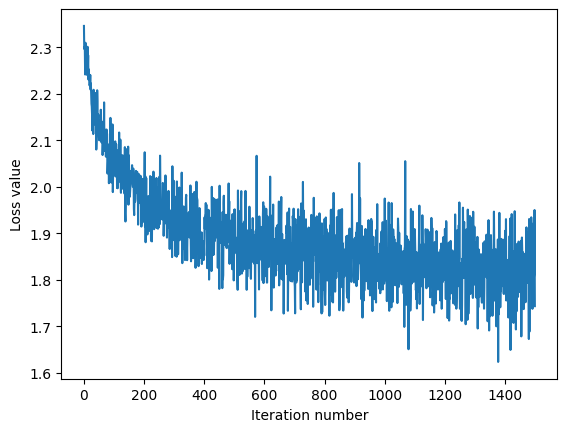

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3816122448979592
validation accuracy: 0.397


## Optimize the softmax classifier

In [12]:
np.finfo(float).eps

2.220446049250313e-16

In [13]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-7, 5e-7, 1e-6, 5e-6, 1e-5]

for lr in learning_rates:
    print('-------------------',str(lr),'--------------------')
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr,
                      num_iters=1500, verbose=True)

    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))
    
learning_rates = [1e-6, 2e-6, 3e-6, 4e-6]

for lr in learning_rates:
    print('-------------------',str(lr),'--------------------')
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr,
                      num_iters=1500, verbose=True)

    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


------------------- 1e-07 --------------------
iteration 0 / 1500: loss 2.3080935028528735
iteration 100 / 1500: loss 2.088078286409454
iteration 200 / 1500: loss 1.9737481671061914
iteration 300 / 1500: loss 1.9009439086653162
iteration 400 / 1500: loss 1.8711769149725495
iteration 500 / 1500: loss 1.9475241088796553
iteration 600 / 1500: loss 1.8817072035481135
iteration 700 / 1500: loss 1.8116596772876468
iteration 800 / 1500: loss 1.9417392765156865
iteration 900 / 1500: loss 1.8116714372917029
iteration 1000 / 1500: loss 1.9543951416368546
iteration 1100 / 1500: loss 1.9205875939965034
iteration 1200 / 1500: loss 1.9156458345487506
iteration 1300 / 1500: loss 1.819541318777948
iteration 1400 / 1500: loss 1.8974927120335088
training accuracy: 0.3806734693877551
validation accuracy: 0.382
------------------- 5e-07 --------------------
iteration 0 / 1500: loss 2.3080935028528735
iteration 100 / 1500: loss 1.9643087008795124
iteration 200 / 1500: loss 1.8179061145096023
iteration 300 

Since the initial learning rate is 1e-7 and based on the graph shows, the loss is decreasing but not smooth enough. Thus, I decided t ostart from 1e-7 and constantly increase the learning rate and find the optimal lr which gives me the best accuracy. I found 2e-6 is a good learning rate with 
### lr: 2e-6
### training accuracy: 0.4265510204081633
### validation accuracy: 0.404